# Lab 3 - Query Expansion

In [13]:
# This cell is the same as Lab 1 till we create the collection collapsed into a single block

import chromadb
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction

from pypdf import PdfReader
from langchain.text_splitter import RecursiveCharacterTextSplitter, SentenceTransformersTokenTextSplitter

reader = PdfReader("microsoft_annual_report_2022.pdf")

pdf_texts = [p.extract_text().strip() for p in reader.pages]

pdf_texts = [text for text in pdf_texts if text]  # Filter the empty strings

character_splitter = RecursiveCharacterTextSplitter(
    separators=["\n\n", "\n", ". ", " ", ""],
    chunk_size=1000,
    chunk_overlap=0
)
character_split_texts = character_splitter.split_text('\n\n'.join(pdf_texts))

token_splitter = SentenceTransformersTokenTextSplitter(chunk_overlap=0, tokens_per_chunk=256)

token_split_texts = []
for text in character_split_texts:
    token_split_texts += token_splitter.split_text(text)
   

embedding_function = SentenceTransformerEmbeddingFunction()

chroma_client = chromadb.Client()


# Use this line if the colletion already exists
chroma_client.delete_collection('MicrosoftAnnualReport')

chroma_collection = chroma_client.create_collection("MicrosoftAnnualReport", embedding_function=embedding_function)

ids = [str(i) for i in range(len(token_split_texts))]

chroma_collection.add(ids=ids, documents=token_split_texts)

chroma_collection.count()

349

In [14]:
# This cell is the same as Lab 2 till we define the project_embeddings method

import umap
import numpy as np
from tqdm import tqdm

embeddings = chroma_collection.get(include=['embeddings'])['embeddings']
umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(embeddings)

def project_embeddings(embeddings, umap_transform):
    umap_embeddings = np.empty((len(embeddings),2))
    for i, embedding in enumerate(tqdm(embeddings)): 
        umap_embeddings[i] = umap_transform.transform([embedding])
    return umap_embeddings   

/Users/damiangarayalde/Desktop/Work - Github Repos/AI/Advanced Retrieval for AI with Chroma/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [15]:
projected_dataset_embeddings = project_embeddings(embeddings, umap_transform)

100%|██████████| 349/349 [01:33<00:00,  3.75it/s]


In [17]:
import os
from openai import OpenAI
from dotenv import load_dotenv, find_dotenv

# Load environment variables
_ = load_dotenv(find_dotenv())  # Read local .env file

# Initialize OpenAI client
openai_client = OpenAI()

## Expansion with generated answers

https://arxiv.org/abs/2305.03653

In [18]:
def augment_query_generated(query, model="gpt-4-turbo"):

    messages = [
        {
            "role": "system",
            "content": (
                        "You are a helpful expert financial research assistant."
                        "Provide an example answer to the given question, that might be found in a document like an annual report. "
            ),
        },
        {"role": "user", "content": query}
    ] 

    response = openai_client.chat.completions.create(
        model=model,
        messages=messages,
    )
    content = response.choices[0].message.content
    return content

In [19]:
original_query      = "How to ask good questions?"
hypothetical_answer = augment_query_generated(original_query)

joint_query = f"{original_query}: {hypothetical_answer}"

print(joint_query)

How to ask good questions?: Asking good questions is essential for acquiring accurate and relevant information, enhancing understanding, and fostering effective communication. Here are several strategies that can lead to the formulation of effective questions:

1. **Be Clear and Concise**: Ensure that your question is straightforward and to the point. Avoid unnecessary complexity that could lead to misunderstandings. Clarity helps the respondent provide the precise information you need.

2. **Be Specific**: General questions can lead to broad answers that might not meet your information needs. Specify the information you are interested in to guide the responses more directly towards your actual requirements.

3. **Do Your Research**: Familiarize yourself with the basic information surrounding your topic. This preparation allows you to ask more informed, detailed questions and shows respect for the respondent's time and effort.

4. **Open-Ended vs. Closed-Ended**: Decide what type of in

In [20]:
results = chroma_collection.query(query_texts=joint_query, n_results=5, include=['documents', 'embeddings'])
retrieved_documents = results['documents'][0]

for doc in retrieved_documents:
    print(doc)
    print('')

45 statement of management ’ s responsibility for financial statements management is responsible for the preparation of the consolidated financial statements and related information that are presented in this report. the consolidated financial statements, which include amounts based on management ’ s estimates and judgments, have been prepared in conformity with accounting principles generally accepted in the united states of america. the company designs and maintains accounting and internal control systems to provide reasonable assurance at reasonable cost that assets are safeguarded against loss from unauthorized use or disposition, and that the financial records are reliable for preparing consolidated financial statements and maintaining accountability for assets. these systems are augmented by written policies, an organizational structure providing division of responsibilities, careful selection and training of qualified personnel, and a program of internal audits.

52 notes to fin

In [21]:
retrieved_embeddings = results['embeddings'][0]
original_query_embedding = embedding_function([original_query])
augmented_query_embedding = embedding_function([joint_query])

projected_original_query_embedding  = project_embeddings(original_query_embedding, umap_transform)
projected_augmented_query_embedding = project_embeddings(augmented_query_embedding, umap_transform)
projected_retrieved_embeddings      = project_embeddings(retrieved_embeddings, umap_transform)

100%|██████████| 5/5 [00:01<00:00,  4.13it/s]


(-3.060415196418762, 7.524823594093323, 1.0972334742546082, 8.713089048862457)

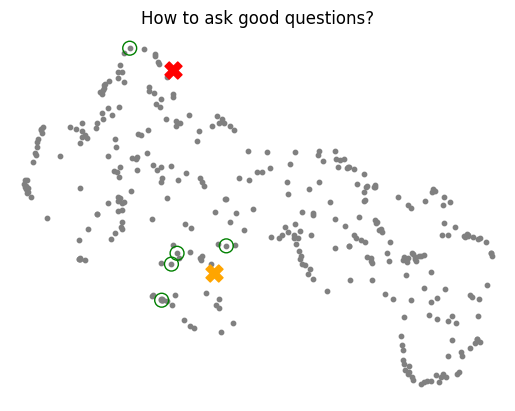

In [22]:
import matplotlib.pyplot as plt

# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')
plt.scatter(projected_original_query_embedding[:, 0], projected_original_query_embedding[:, 1], s=150, marker='X', color='r')
plt.scatter(projected_augmented_query_embedding[:, 0], projected_augmented_query_embedding[:, 1], s=150, marker='X', color='orange')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{original_query}')
plt.axis('off')

## Expansion with multiple queries


In [23]:
def augment_multiple_query(query, model="gpt-4-turbo"):
    messages = [
        {
            "role": "system",
            "content": "You are a helpful expert financial research assistant. Your users are asking questions about an annual report. "
            "Suggest up to five additional related questions to help them find the information they need, for the provided question. "
            "Suggest only short questions without compound sentences. Suggest a variety of questions that cover different aspects of the topic."
            "Make sure they are complete questions, and that they are related to the original question."
            "Output one question per line. Do not number the questions."
        },
        {"role": "user", "content": query}
    ]

    response = openai_client.chat.completions.create(
        model=model,
        messages=messages,
    )
    content = response.choices[0].message.content
    content = content.split("\n")
    return content

In [24]:
original_query = "What were the most important factors that contributed to increases in revenue?"
augmented_queries = augment_multiple_query(original_query)

for query in augmented_queries:
    print(query)

What new products or services were launched last year?
What changes were made to the pricing strategy?
How did market expansion impact revenue growth?
What was the role of acquisitions in revenue growth?
How did customer retention rates change during the year?


In [25]:
queries = [original_query] + augmented_queries
results = chroma_collection.query(query_texts=queries, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents']

# Deduplicate the retrieved documents
unique_documents = set()
for documents in retrieved_documents:
    for document in documents:
        unique_documents.add(document)

for i, documents in enumerate(retrieved_documents):
    print(f"Query: {queries[i]}")
    print('')
    print("Results:")
    for doc in documents:
        print(doc)
        print('')
    print('-'*100)

Query: What were the most important factors that contributed to increases in revenue?

Results:
engineering, gaming, and linkedin. • sales and marketing expenses increased $ 1. 7 billion or 8 % driven by investments in commercial sales and linkedin. sales and marketing included a favorable foreign currency impact of 2 %. • general and administrative expenses increased $ 793 million or 16 % driven by investments in corporate functions. operating income increased $ 13. 5 billion or 19 % driven by growth across each of our segments. current year net income and diluted eps were positively impacted by the net tax benefit related to the transfer of intangible properties, which resulted in an increase to net income and diluted eps of $ 3. 3 billion and $ 0. 44, respectively. prior year net income and diluted eps were positively impacted by the net tax benefit related to the india supreme court decision on withholding taxes, which resulted in an increase to net income and diluted eps of $ 620 

In [26]:
original_query_embedding = embedding_function([original_query])
augmented_query_embeddings = embedding_function(augmented_queries)

project_original_query = project_embeddings(original_query_embedding, umap_transform)
project_augmented_queries = project_embeddings(augmented_query_embeddings, umap_transform)

100%|██████████| 5/5 [00:01<00:00,  3.54it/s]


In [27]:
result_embeddings = results['embeddings']
result_embeddings = [item for sublist in result_embeddings for item in sublist]
projected_result_embeddings = project_embeddings(result_embeddings, umap_transform)

100%|██████████| 30/30 [00:07<00:00,  3.79it/s]


(-3.060415196418762, 7.524823594093323, 1.0972334742546082, 8.713089048862457)

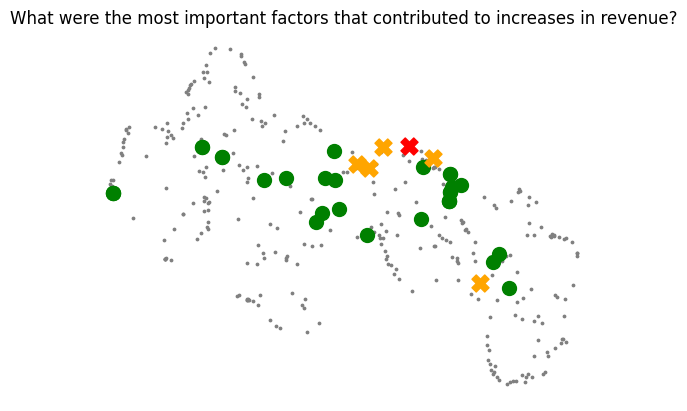

In [28]:
import matplotlib.pyplot as plt

plt.figure()

plt.scatter(projected_dataset_embeddings[  :, 0], projected_dataset_embeddings[  :, 1], s=3, color='gray')
plt.scatter(projected_result_embeddings[:, 0],    projected_result_embeddings[:, 1], s=100, facecolors='g', edgecolors='g')
plt.scatter(project_augmented_queries[:, 0],      project_augmented_queries[:, 1],       s=150, marker='X', color='orange')
plt.scatter(project_original_query[     :, 0],    project_original_query[     :, 1], s=150, marker='X', color='r')



plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{original_query}')
plt.axis('off')